In [1]:
import os 
cwd = os.getcwd()
print(cwd)

d:\xhou4\ML_CVR\smooth8\ML_data\script_test


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

import os
import fnmatch
import nibabel as nib
import glob

In [3]:
cwd

'd:\\xhou4\\ML_CVR\\smooth8\\ML_data\\script_test'

In [4]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Sequential(
            nn.Conv2d(prev_channels, n_classes, kernel_size=1),
            nn.Tanh())            

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


In [16]:
import torch
from torch.utils import data
import nibabel as nib

class CVRDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_root):
        'initialization'
        self.input_IDs = []
        self.label_IDs = []
        'Find the file location'
        for subname in os.listdir(data_root):
            if os.path.isdir(os.path.join(data_root, subname)):
                for subfile in os.listdir(os.path.join(data_root, subname)):
                    if fnmatch.fnmatch(subfile, 'bold_cov_0*'):
            
                        sub_filepath = os.path.join(data_root, subname, subfile)
                        self.input_IDs.append(sub_filepath)
                    
                for tarfile in os.listdir(os.path.join(data_root, subname, 'HC')):
                    if fnmatch.fnmatch(tarfile, 'CVR_HC_clean_0*'):
                        
                        target_filepath = os.path.join(data_root, subname, 'HC', tarfile)
                        self.label_IDs.append(target_filepath)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.input_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        'initialization'
        input_x = []
        label_y = []
        
        # Select input
        input_ID = self.input_IDs[index]
#         print(input_ID)
        
        # Load input
        img = nib.load(input_ID)
        train_image = img.get_fdata()
        train_image = train_image.astype(np.float32)
        img.uncache()

#         train_image = np.pad(train_image, ((2, 3), (1, 2), (0, 0)), 'constant') #pad zero surrounding the image
        train_image = np.transpose(train_image, (2, 0, 1))
        
        A = torch.Tensor(train_image).type(torch.FloatTensor)
        
        # Select label
        label_ID = self.label_IDs[index]
#         print(label_ID)
        
        # Load label
        taimg = nib.load(label_ID)
        label_image = taimg.get_fdata()
        label_image = label_image.astype(np.float32)
        taimg.uncache()
        
#         label_image = np.pad(label_image, ((2, 3), (1, 2)), 'constant') #pad zero surrounding the image

        B = torch.Tensor(label_image).type(torch.FloatTensor)
        return [A, B]

In [17]:
import torch
from torch.utils import data

# Generators
training_set = CVRDataset('d:\\xhou4\\ML_CVR\\smooth8\\ML_data\\train')
CVRdata = data.DataLoader(training_set, batch_size=64, shuffle=True)

x, y = next(iter(CVRdata))
print(x.shape)
print(y.shape)

torch.Size([64, 30, 96, 112])
torch.Size([64, 96, 112])


Epoch number 1, Step [10/148], Loss: 0.1795 
Epoch number 1, Step [20/148], Loss: 0.0945 
Epoch number 1, Step [30/148], Loss: 0.0835 
Epoch number 1, Step [40/148], Loss: 0.0777 
Epoch number 1, Step [50/148], Loss: 0.0738 
Epoch number 1, Step [60/148], Loss: 0.0722 
Epoch number 1, Step [70/148], Loss: 0.0681 
Epoch number 1, Step [80/148], Loss: 0.0593 
Epoch number 1, Step [90/148], Loss: 0.0514 
Epoch number 1, Step [100/148], Loss: 0.0420 
Epoch number 1, Step [110/148], Loss: 0.0323 
Epoch number 1, Step [120/148], Loss: 0.0327 
Epoch number 1, Step [130/148], Loss: 0.0264 
Epoch number 1, Step [140/148], Loss: 0.0261 
Epoch number 2, Step [10/148], Loss: 0.0261 
Epoch number 2, Step [20/148], Loss: 0.0264 
Epoch number 2, Step [30/148], Loss: 0.0241 
Epoch number 2, Step [40/148], Loss: 0.0252 
Epoch number 2, Step [50/148], Loss: 0.0220 
Epoch number 2, Step [60/148], Loss: 0.0230 
Epoch number 2, Step [70/148], Loss: 0.0258 
Epoch number 2, Step [80/148], Loss: 0.0230 
Epoch

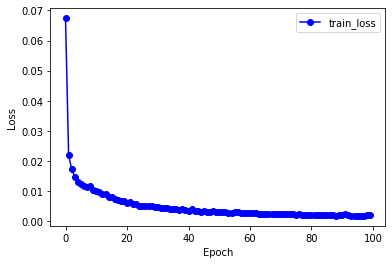

In [18]:
import math
import torch
from torch.utils import data

# Generators
training_set = CVRDataset('d:\\xhou4\\ML_CVR\\smooth8\\ML_data\\train')
dataloader = data.DataLoader(training_set, batch_size=64, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=30, n_classes=1, depth = 5, padding=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
epochs = 100

total_step = len(dataloader)
loss_list = []

for t in range(epochs):

    running_loss = 0.0
    batch_loss = 0.0
    step_count = 0.0
    for i, (X, y) in enumerate(dataloader):
        X = X.to(device)  # [N, 6, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = np.squeeze(model(X))  # [N, H, W]

        loss = criterion(prediction, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if math.isnan(loss.item()) == False:
            batch_loss += loss.item()
            step_count += 1

        if (i + 1) % 10 == 0:
            running_loss += batch_loss
            print('Epoch number {}, Step [{}/{}], Loss: {:.4f} '
                      .format(t + 1, i + 1, total_step, loss.item()))
            batch_loss = 0.0

    loss_list.append(running_loss/step_count)

## Plotting batch-wise train loss curve:
plt.plot(loss_list, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
test_dir = 'd:\\xhou4\\ML_CVR\\smooth8\\ML_data\\test'
os.chdir(test_dir)

model.eval()
with torch.no_grad():
    for subname in glob.glob('*\\'):
        test_result = np.zeros((96, 112, 91))

        tensor_x = []
        tensor_y = []

        sub_filename = os.path.join(test_dir, subname, 'bold_cov_rp_c.nii')
        print(sub_filename)
        img = nib.load(sub_filename)
        img_data = img.get_fdata()
        img.uncache()

        for i in range(80):
            train_image = np.squeeze(img_data[:, :, i, :])
            train_image = np.pad(train_image, ((2, 3), (1, 2), (0, 0)), 'constant') #pad zero surrounding the image
            train_image = np.transpose(train_image, (2, 0, 1))
            tensor_x.append(torch.Tensor(train_image))

        target_filename = os.path.join(test_dir, subname, 'HC/CVR_HC_clean.nii')
        print(target_filename)
        taimg = nib.load(target_filename)
        taimg_data = taimg.get_fdata()    
        taimg.uncache()

        for i in range(80):
            label_image = np.squeeze(taimg_data[:, :, i])
            label_image = np.pad(label_image, ((2, 3), (1, 2)), 'constant') #pad zero surrounding the image
            tensor_y.append(torch.Tensor(label_image))

        tensor_x_stacked = torch.stack(tensor_x)
        tensor_y_stacked = torch.stack(tensor_y)

        test_data = torch.utils.data.TensorDataset(tensor_x_stacked,tensor_y_stacked)
        testloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=1)

        i = 0
        for X, y in testloader:
            X = X.to(device)
        #         plt.imshow(X[0][1]) 
        #         plt.show()
            outputs = np.squeeze(model(X).cpu().clone().numpy())
            test_result[:, :, i] = outputs
            i += 1

        img_output = nib.Nifti1Image(test_result, taimg.affine)
        img_output.get_data_dtype() == np.dtype(np.int16)
        nib.save(img_output, os.path.join(test_dir, subname, 'ML_cov_result.nii'))


d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_mr1_ma110116\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_mr1_ma110116\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_ac033017\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_ac033017\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_as061418\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_as061418\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_bm011118\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_bm011118\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_hl042519\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_hl042519\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_se082318\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_se082318\HC/CVR_HC_clean.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_ta011818\bold_cov_rp_c.nii
d:\xhou4\ML_CVR\smooth8\ML_data\test\hlu_xmr_ta01181

In [20]:
torch.save(model.state_dict(), 'd:/xhou4/ML_CVR/smooth8/ML_data/Unet_cov_train_model_norm_135sub.pt')